# Title Here

Calvin Davis, Sabine May, Braden Nowicki, and Hudson Jones

## Introduction

- need to include motivation, brief description of data science pipeline, and overview on how we are applying that pipeline to our dataset(s)

Motivating article: https://www.birds.cornell.edu/home/bring-birds-back/#:~:text=NARRATOR%3A%20Birds%20are%20losing%20the,toxic%20pesticides%20and%20insect%20declines. 
- maybe specifically look at the common bird species that are mentioned in that article in the databases we analyze? 
- maybe look specifically at common bird specis in maryland? 
- red-winged blackbird mentioned in motivating article is common throughout the chespeake bay region: https://www.chesapeakebay.net/discover/field-guide/entry/red-winged-blackbird#:~:text=The%20red%2Dwinged%20blackbird%20is,dull%20brown%20with%20dark%20streaks. 
- Red-winged Blackbird AOU: 04980
- maybe want to correlate bird loss with excessive noise, relate to noise pollution in CP? 
- mayrland state num: 46
- Mass state num: 47

## Imports

Description of the libraries we're using/links to their tutorials and documentation

In [6]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sqlite3

## Data Collection

### Reading the READMEs

In [7]:
# Unfortunately, our data is in downloadable .blah files, so we can't use scrape anything 
# automatically using Python's Requests library. Go to *link* and downloade following files: 
# *files*. Save them in your current directory under a folder called raw-date. Note that you will 
# need to expand the zip files *files*. Look through the files to get a feel for how the data is
# is formatted, and skim the README provided on the webiste. Here are some excerpts from that 
# readme that will be important for the data we actually want to process: 

# RPID = run protocol ID
# AOU = 5-digit special identification number, primary key in 50-stop data seems to be
# (RouteDataID, AOU) <- "Data identification number; unique for each combination of CountryNum, StateNum, Route, RPID, and Year"
# StopTotal = 
# SpeciesTotal = 
# Route = 3 digit code that identifies the route, unique within states 


# verify that we know what we're talking about here: 
# sum across frist row of fifty point total (alberta, state num: 04, route num: 6167164) with 
# corresponding total column in Alberta.csv (they are both 17, yay, but do it in code as well)

## Data Processing

### Cleaning Data on Maryland Bird Routes

In [45]:
# get rid of anything that uses different sampling protocol (RPID)
# use RPID 101 - 104: Standard BBS Protocol: 3-minute counts, 1 observer, 
# single/second/third/fourth run per year. Average the counts accross runs? This makes sense 
# because the data is "collected annually during the breeding season, primarily in June" 
# so multiple runs should still be happening around the same time period. 

# limit to certain species 
# get rid of rows in vehicle data that have NULLs in recorded cars
# limit to last 50 years (this may contradict with when sampling recorded cars was consistent)


md_routes = pd.read_csv("../Data/States/Marylan.csv")
md_routes.head(5)

,RouteDataID,CountryNum,StateNum,Route,RPID,Year,AOU,Count10,Count20,Count30,Count40,Count50,StopTotal,SpeciesTotal
0,6238625,840,46,1,101,1966,2730,0,1,0,0,0,1,1
1,6238625,840,46,1,101,1966,3160,1,0,0,0,0,1,1
2,6238625,840,46,1,101,1966,3250,0,0,0,1,3,4,4
3,6238625,840,46,1,101,1966,3880,0,0,0,1,0,1,1
4,6238625,840,46,1,101,1966,3930,0,1,0,0,0,1,1


In [46]:
# md_routes = md_routes[md_routes['RPID'] == 101]
md_routes[(md_routes['RPID'] >= 101) & (md_routes['RPID'] <= 104)]

#(RouteDataID, AOU) <- "Data identification number; unique for each combination of CountryNum, StateNum, Route, RPID, and Year"
# Since we're already in the maryland file, (CountryNum, StateNum) will be same for all rows, and Route
# is unique within states. So, all we need to identify a unique row is Route, Year, RPID, and AOU. Let's group on RPID
# in order to take averages if multiple runs were recorded
md_routes = md_routes.groupby(['Route', 'Year', 'AOU']).agg({'Count10':['mean'], 'Count20':['mean'], 'Count30':['mean'], 'Count40':['mean'], 'Count50':['mean'], 'StopTotal':['mean'], 'SpeciesTotal':['mean']})
md_routes.head(5)


Count10 Count20 Count30 Count40 Count50 StopTotal SpeciesTotal
                   mean    mean    mean    mean    mean      mean         mean
Route Year AOU                                                                
1     1966 2730     0.0     1.0     0.0     0.0     0.0       1.0          1.0
           3160     1.0     0.0     0.0     0.0     0.0       1.0          1.0
           3250     0.0     0.0     0.0     1.0     3.0       4.0          4.0
           3880     0.0     0.0     0.0     1.0     0.0       1.0          1.0
           3930     0.0     1.0     0.0     0.0     0.0       1.0          1.0

In [47]:
# flatten the multiindices in both the columns and rows
md_routes.columns = ['_'.join(col) for col in md_routes.columns.values]
md_routes.reset_index(inplace=True)
md_routes.head(5)

,Route,Year,AOU,Count10_mean,Count20_mean,Count30_mean,Count40_mean,Count50_mean,StopTotal_mean,SpeciesTotal_mean
0,1,1966,2730,0.0,1.0,0.0,0.0,0.0,1.0,1.0
1,1,1966,3160,1.0,0.0,0.0,0.0,0.0,1.0,1.0
2,1,1966,3250,0.0,0.0,0.0,1.0,3.0,4.0,4.0
3,1,1966,3880,0.0,0.0,0.0,1.0,0.0,1.0,1.0
4,1,1966,3930,0.0,1.0,0.0,0.0,0.0,1.0,1.0


In [57]:
md_routes_sum = md_routes.groupby(['Year']).agg({'Count10_mean':['sum'], 'Count20_mean':['sum'], 'Count30_mean':['sum'], 'Count40_mean':['sum'], 'Count50_mean':['sum'], 'StopTotal_mean':['sum'], 'SpeciesTotal_mean':['sum']})
# flatten the multiindices in both the columns and rows
md_routes_sum.columns = ['_'.join(col) for col in md_routes_sum.columns.values]
md_routes_sum.reset_index(inplace=True)
md_routes_sum.head(5)

,Year,Count10_mean_sum,Count20_mean_sum,Count30_mean_sum,Count40_mean_sum,Count50_mean_sum,StopTotal_mean_sum,SpeciesTotal_mean_sum
0,1966,9974.000000,11284.0,10562.000000,9221.000000,8910.000000,22245.0,49951.000000
1,1967,10319.000000,11081.0,9918.000000,10009.000000,9733.000000,22435.0,51060.000000
2,1968,9938.000000,9873.0,9549.000000,9370.500000,8234.500000,20444.0,46965.000000
3,1969,8883.333333,10120.0,9897.333333,9139.333333,9225.833333,21306.5,47265.833333
4,1970,8696.000000,10338.0,9849.000000,9195.000000,9414.000000,22028.0,47492.000000


### Cleaning Data on Maryland Vehicles

In [64]:
vehicles = pd.read_csv("../Data/VehicleData.csv")
vehicles.head(5)

,RouteDataID,CountryNum,StateNum,Route,RPID,Year,RecordedCar,Car1,Car2,Car3,...,Noise41,Noise42,Noise43,Noise44,Noise45,Noise46,Noise47,Noise48,Noise49,Noise50
0,6167164,124,4,1,101,2000,NaN,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,6248812,124,4,1,101,2005,1.0,3,4,5,...,0,0,0,0,0,0,0,0,0,0
2,6297584,124,4,1,101,2006,NaN,5,5,4,...,0,0,0,0,0,0,0,0,0,0
3,6297586,124,4,1,101,2007,NaN,4,4,2,...,0,0,0,0,0,0,0,0,0,0
4,6358333,124,4,1,101,2015,1.0,1,1,0,...,0,0,0,0,0,0,0,0,0,0


In [69]:
# get rid of anything that's not certain (NaNs in RecordedCards or 0s in RecordedCar)
# the .drop() is an alternative to vehciles = vehicles[vehicles['RecordedCar' == 1]] and allows us to do this
# removal in one line
vehicles = vehicles.fillna(0).drop(vehicles[vehicles['RecordedCar'] == 0].index)

# also get rid of things that aren't Maryland (statenum = 46, countrynum = 840)
vehicles = vehicles[(vehicles['StateNum'] == 46) & (vehicles['CountryNum'] == 840)]
vehicles = vehicles.groupby(['Route', 'RPID', 'Year'])
vehicles.head(5)


,RouteDataID,CountryNum,StateNum,Route,RPID,Year,RecordedCar,Car1,Car2,Car3,...,Noise41,Noise42,Noise43,Noise44,Noise45,Noise46,Noise47,Noise48,Noise49,Noise50
36746,6233501,840,46,1,101,1998,1.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
36747,6224420,840,46,1,101,1999,1.0,0,0,0,...,0,0,1,1,0,0,1,0,0,0
36748,6238108,840,46,1,101,2000,1.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
36749,6243521,840,46,1,101,2001,1.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
36750,6167862,840,46,1,101,2003,1.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Exploratory Analysis and Data Visualization

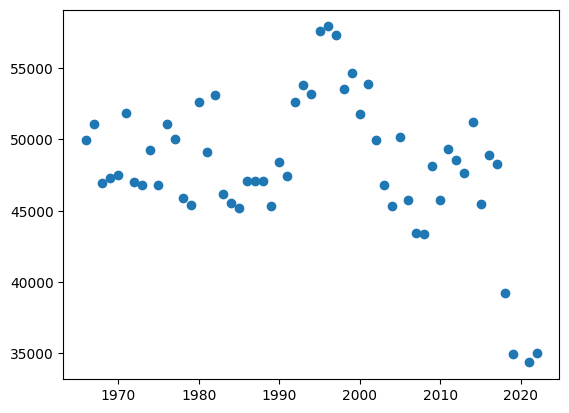

In [61]:
# average number of birds seen across all routes in maryland each year
plt.scatter(md_routes_sum['Year'], md_routes_sum['SpeciesTotal_mean_sum'])

In [ ]:
plt.scatter()

## Hypothesis Testing and Machine Learning